In [10]:
import numpy as np
import matplotlib.pyplot as plt
from correlations.density_correlations import oil_density
from correlations.data import roW, T0, vH2, vH2S, get_API, get_volume_molar_oil
from correlations.solubility import get_viscosity, get_Henry_H2, get_Henry_H2S
from correlations.mass_transfer import aS_fun, kiL_aL_fun, kiS_aS_fun,  get_diffusion_oil, get_diffusion_H2, get_diffusion_H2S
from correlations.kinetics_vacuum_gas_oil import fKH2S, rHDS
from scipy.integrate import solve_ivp
from scipy.optimize import root

## Reactor

In [11]:
porosity = 0.48 #value calculate using values of first article = 0.48

eta = 0.5

dp = 0.172 #equivalent diameter in cm

z = 70 #lenght of reactor in cm

diameter_reactor = 3 #diameter of the reactor in cm

Ac = np.pi*diameter_reactor**2/4

aS = aS_fun(porosity, dp)

## Fluid

In [12]:
T = 370+273.15 #Temperature of operation in K.

P = 10 #Pressure in inlet in Pa.

rho0 = 0.9146 #Density of oil at 15.6°C in kg/m^3.

rhob = 0.8163 #bulk density in g/cm^3

roW = 0.999007 #density of water at 15.6°C in kg/m^3.

Mm = 420 #molecuar weigth of the oil.

T_MeABP = (451 + 273.15)*1.8 # Mean average boiling point of oil in °R.

w1 = 0.02 #weigth fraction of sulfur.

d15_6 = rho0/roW #Specific gravity of oil.

API = get_API(d15_6) #API gravity of oil.

WHSV = 0.85 #weight hour velocity

vL = get_volume_molar_oil(T_MeABP, d15_6, Mm)

viscosity = get_viscosity(T, API)

rhoL = oil_density(rho0,P,T)
diffusion_oil = get_diffusion_oil(T,viscosity, vL)
diffusion_H2 = get_diffusion_H2(T, viscosity, vL, vH2)
diffusion_H2S = get_diffusion_H2S(T, viscosity, vL, vH2S)
Henry_H2 = get_Henry_H2(rho0, P, T)
Henry_H2S = get_Henry_H2S(rho0, P, T)
GL = WHSV*160/Ac/3600
uL = GL/oil_density(rho0,P,T)
uG = uL*1000*(1/100)*(T/T0)
kLaL_H2 = kiL_aL_fun(diffusion_H2, viscosity, rho0, P, T, GL)
kLaL_H2S = kiL_aL_fun(diffusion_H2S, viscosity, rho0, P, T, GL) 
kSaS_oil = kiS_aS_fun(diffusion_oil, viscosity, rho0, P, T, GL, aS)
kSaS_H2 = kiS_aS_fun(diffusion_H2, viscosity, rho0, P, T, GL, aS)
kSaS_H2S = kiS_aS_fun(diffusion_H2S, viscosity, rho0, P, T, GL, aS)

## Differential Equations

In [13]:
def mass_balance_gas_phase2(p2G, C2L, uG = uG, R=8.3145, T = T): #equation 7

    return - kLaL_H2 * (p2G / Henry_H2 - C2L) * R * T / uG 

def mass_balance_gas_phase4(p4G, C4L, uG = uG, R=8.3145, T = T): #equation 8

    return - kLaL_H2S * (p4G / Henry_H2S- C4L) * R * T / uG

def mass_balance_gas_liquid_phase2(p2G, C2L, C2S, uL = uL): #equation 9

    return (kLaL_H2 * (p2G / Henry_H2 - C2L) -  kSaS_H2 * (C2L - C2S)) / uL

def mass_balance_gas_liquid_phase4(p4G, C4L, C4S, uL = uL): #equation 10
    
    return (kLaL_H2S * (p4G / Henry_H2S - C4L) -  kSaS_H2S * (C4L - C4S)) / uL

def mass_balance_liquid(C1L, C1S, uL = uL): #equation 11

    return - (C1L - C1S) * kSaS_oil / uL

## Kinetics

In [14]:
KH2S = fKH2S(T)

def constraints(C,liquid_concentrations):

    ni1 = -1 
    ni2 = -15
    ni4 = 9
    efectiveness = 1

    C1S = C[0]
    C2S = C[1]
    C4S = C[2]

    F = np.empty((3))
    F[0] =  - ni1 * eta*efectiveness*rhob *rHDS(C1S, C2S, C4S,KH2S) - kSaS_oil * (liquid_concentrations[0] - C1S)
    F[1] =  - ni2 * eta*efectiveness*rhob *rHDS(C1S, C2S, C4S, KH2S) - kSaS_H2 * (liquid_concentrations[1] - C2S)
    F[2] =  - ni4 * eta*efectiveness*rhob *rHDS(C1S, C2S, C4S, KH2S) - kSaS_H2S * (liquid_concentrations[2] - C4S)

    return F

## Initial Conditions

In [15]:
p2G0 = P # inlet pressure of gas hydrogen in MPa.
p4G0 = 0 # inlet pressure of hydrogen sulfite in MPa.
C1L0 = oil_density(rho0,P,T)*w1/Mm #inlet concentration of sulfur liquid in mol/cm^3
C2L0 = p2G0/Henry_H2 #inlet concentration of hydrogen in mol/cm^3 .
C4L0 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .

Cls = [C1L0, C2L0, C4L0]

## Integration

In [16]:
def dy(z, variables):

    p2G, p4G, C2L, C4L,  C1L = variables
    
    solid_concentrations = root(constraints, Cls, [C1L, C2L, C4L], method = "lm").x


    return np.array([mass_balance_gas_phase2(p2G, C2L),
     mass_balance_gas_phase4(p4G, C4L),
     mass_balance_gas_liquid_phase2(p2G, C2L, solid_concentrations[1]),
     mass_balance_gas_liquid_phase4(p4G, C4L, solid_concentrations[2]),
     mass_balance_liquid(C1L, solid_concentrations[0])
    ])

t_span = [0, z]
t_eval = np.linspace(0, z, 1000)
y0 = [p2G0, p4G0, C2L0, C4L0, C1L0]

sol = solve_ivp(dy, t_span=t_span, y0=y0, t_eval=t_eval, method = "LSODA")

p2G_fun, p4G_fun, C2L_fun, C4L_fun,  C1L_fun = sol.y

CS1_fun = []
CS2_fun = []
CS4_fun = []

for i in range(len(C2L_fun)):

    [CS1, CS2, CS4] = root(constraints, [C1L_fun[i], C2L_fun[i], C4L_fun[i]], [C1L_fun[i], C2L_fun[i], C4L_fun[i]], method = "lm",).x

    CS1_fun.append(CS1)
    CS2_fun.append(CS2)
    CS4_fun.append(CS4)

CS1_fun = np.array(CS1_fun)
CS2_fun = np.array(CS2_fun)
CS4_fun = np.array(CS4_fun)

## Analysis

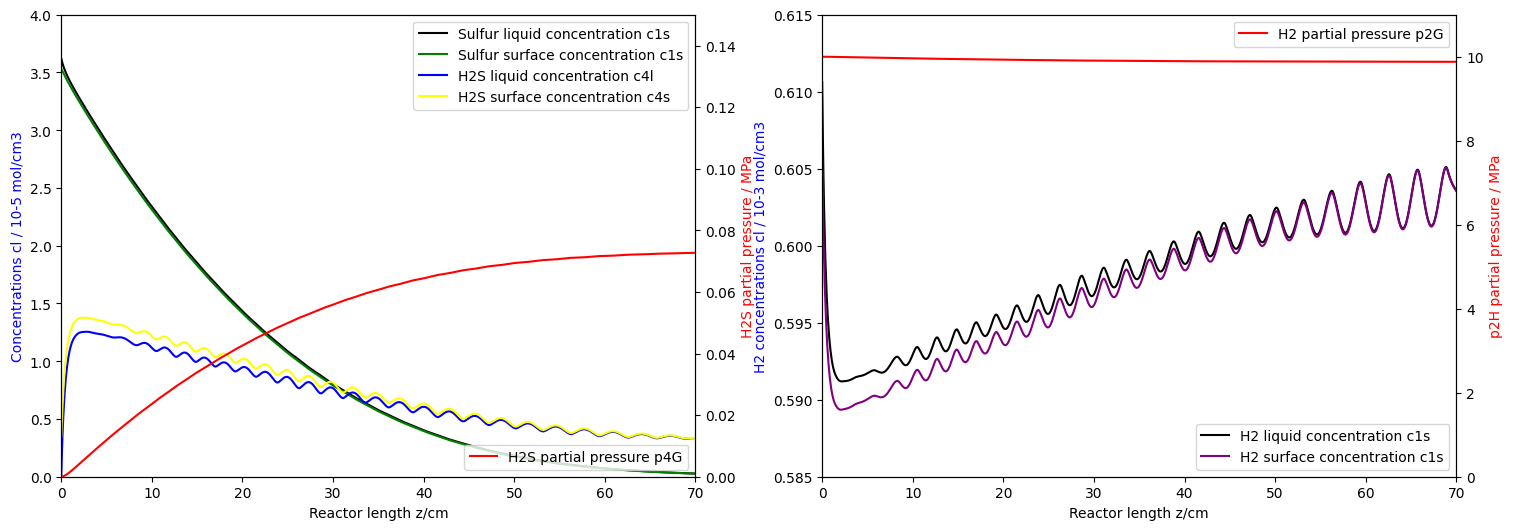

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first dataset (y_values1) on the left axis (Y-axis)
ax[0].plot(t_eval, C1L_fun*1e5, label='Sulfur liquid concentration c1s', color='black')
ax[0].plot(t_eval, CS1_fun*1e5, label='Sulfur surface concentration c1s', color='green')
ax[0].plot(t_eval, C4L_fun*1e5, label='H2S liquid concentration c4l', color='blue')
ax[0].plot(t_eval, CS4_fun*1e5, label='H2S surface concentration c4s', color='yellow')

ax[0].set_xlim(0,z)
ax[0].set_ylim(0,4)
# Create a second Y-axis on the right side of the graph
ax2 = ax[0].twinx()

# Plot the second dataset (y_values2) on the right axis (Y-axis)
ax2.plot(t_eval, p4G_fun, label='H2S partial pressure p4G', color='red')
# Add labels and a legend
ax[0].set_xlabel('Reactor length z/cm')
ax[0].set_ylabel('Concentrations cl / 10-5 mol/cm3', color='blue')
ax2.set_ylabel('H2S partial pressure / MPa', color='red')
ax2.set_ylim(0,0.15)

# Add a legend
ax[0].legend(loc='upper right')
ax2.legend(loc='lower right')

ax[1].plot(t_eval, C2L_fun*1e3, label='H2 liquid concentration c1s', color='black')
ax[1].plot(t_eval, CS2_fun*1e3, label='H2 surface concentration c1s', color='purple')


ax[1].set_xlim(0, z)
ax[1].set_ylim(0.585,0.615)

#Create a second Y-axis on the right side of the graph
ax4 = ax[1].twinx()

# Plot the second dataset (y_values2) on the right axis (Y-axis)
ax4.plot(t_eval, p2G_fun, label='H2 partial pressure p2G', color='red')
# Add labels and a legend
ax[1].set_xlabel('Reactor length z/cm')
ax[1].set_ylabel('H2 concentrations cl / 10-3 mol/cm3', color='blue')
ax4.set_ylabel('p2H partial pressure / MPa', color='red')
ax4.set_ylim(0,11)

# Add a legend
ax[1].legend(loc='lower right')
ax4.legend(loc='upper right')

# Display the graph
plt.show()
